In [1]:
import numpy as np
import torch
import torch as tr
import torch.nn.functional as F
import torchvision as tv
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")
data

NpzFile 'tiny_nerf_data.npz' with keys: images, poses, focal

In [3]:
def resize_to(images, height, width):
    # images: (B, old_H, old_W, C)

    # (B, C, old_H, old_W)
    images = images.permute(0, 3, 1, 2)

    transform = tv.transforms.Compose([
        tv.transforms.Resize((height, width))
    ])

    # (B, C, new_H, new_W)
    resized_images = torch.stack([
        # (C, new_H, new_W)
        transform(image)
        for image in images
    ])

    # (B, new_H, new_W, C)
    resized_images = resized_images.permute(0, 2, 3, 1)

    return resized_images


In [4]:
images = data['images']
poses = data['poses']
focal_length = data['focal']

# Images
# (B, H, W, C)
images = torch.from_numpy(images)
images = resize_to(images, 32, 32)
# Camera extrinsics (poses)
poses = torch.from_numpy(poses)
# Focal length (intrinsics)
focal_length = torch.from_numpy(focal_length)
# Rescale focal length
focal_length = focal_length * 32.0 / 100.0

print(images.shape)
print(poses.shape)
print(focal_length)

height, width = images.shape[1:3]

torch.Size([106, 32, 32, 3])
torch.Size([106, 4, 4])
tensor(44.4444, dtype=torch.float64)


In [5]:
def nf_get_ray_bundle(
    height: int,
    width: int,
    focal_length: torch.Tensor,
    pose: torch.Tensor
):
    points_x, points_y = torch.meshgrid(
        torch.arange(width),
        torch.arange(height),
        indexing='xy'
    )

    points_x = (points_x - width / 2.0) / focal_length
    # Note the -ve here, y in grid increases downwards while
    # y in NDC increases upwards
    points_y = -(points_y - height / 2.0) / focal_length
    points_z = -tr.ones_like(points_x)

    ray_dirs = tr.stack(
        (
            points_x,
            points_y,
            points_z,
        ),
        dim=-1
    )

    ray_dirs = F.normalize(ray_dirs, dim=-1)

    transform_rot = pose[:3, :3]
    ray_dirs = ray_dirs @ transform_rot.T

    ray_origins = pose[:3, -1].expand(ray_dirs.shape)

    return ray_origins, ray_dirs


In [6]:
def nf_create_query_points(
    # (H, W, 3)
    ray_origins: torch.Tensor,
    # (H, W, 3)
    ray_dirs: torch.Tensor,
    thresh_near: float,
    thresh_far: float,
    num_samples_per_ray: int,
):
    # TODO: randomize

    # (N,)
    depths = torch.linspace(thresh_near, thresh_far, num_samples_per_ray)

    # (H, W, N, 3)
    query_points = (
        ray_origins[..., None, :]
        + ray_dirs[..., None, :] * depths[:, None]
    )

    return query_points, depths


In [7]:
def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    cumprod = torch.cumprod(tensor, dim=-1)
    cumprod = torch.roll(cumprod, 1, dims=-1)
    cumprod[..., 0] = 1.
    return cumprod

In [8]:
def nf_render_view(
    # (H, W, N, 4)
    view_field: torch.Tensor,
    # (N,) or (H, W, N)
    depths: torch.Tensor,
):
    # (H, W, N, 3)
    rgb_field = view_field[..., :3]
    # (H, W, N)
    sigma_field = view_field[..., 3]

    rgb_field = F.sigmoid(rgb_field)
    sigma_field = F.relu(sigma_field)

    # (*, N - 1)
    deltas = depths[..., 1:] - depths[..., :-1]

    # (*, N)
    deltas = torch.cat(
        (
            # (*, N - 1)
            deltas,
            # (*, 1)
            torch.tensor([1e10]).expand(deltas[..., :1].shape)
        ),
        dim=-1
    )

    # (H, W, N)
    alpha = 1. - torch.exp(-sigma_field * deltas)
    # (H, W, N)
    weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

    # (H, W, N, 3)
    rgb_map_points = (
      # (H, W, N, 1)
      weights[..., None]
      *
      # (H, W, N, 3)
      rgb_field
    )

    # (H, W, 3)
    rgb_map = rgb_map_points.sum(dim=-2)

    return rgb_map



In [9]:
def positional_encoding(
    # (*, D (3))
    points,
    L=6,
):
    encoding = [points]

    freqs = 2.0 ** torch.linspace(0.0, L - 1, L)

    for freq in freqs:
        encoding.append(torch.sin(points * freq))
        encoding.append(torch.cos(points * freq))

    if len(encoding) == 1:
        return encoding[0]
    else:
        return torch.cat(encoding, dim=-1)


def split_points_into_chunks(
    # (B, L)
    points: torch.Tensor,
    chunk_size: int
):
    return [
        points[i:i + chunk_size]
        for i in range(0, points.shape[0], chunk_size)
    ]

In [10]:
def nf_render_pose(
    model: torch.nn.Module,
    height: int,
    width: int,
    focal_length: torch.Tensor,
    pose: torch.Tensor,
    thresh_near: int,
    thresh_far: int,
    num_samples_per_ray: int,
    chunk_size: int,
):

    # Create rays
    ray_origins, ray_dirs = nf_get_ray_bundle(
        height,
        width,
        focal_length,
        pose
    )

    # Create query points
    query_points, depths = nf_create_query_points(
        ray_origins,
        ray_dirs,
        thresh_near,
        thresh_far,
        num_samples_per_ray,
    )

    # pass query points to model
    """
    model: (B, 3) -> (B, 4)
    """

    # (H, W, N, 3)
    # query_points

    # ============ create input ============

    # (H*W*N, 3)
    flat_query_points = query_points.view(-1, 3)
    # (H*W*N, Lx)
    flat_query_points = positional_encoding(flat_query_points)

    # (H, W, N, Ld)
    rd_per_point = ray_dirs[..., None, :].expand(query_points.shape)
    # (H*W*N, Ld)
    flat_rd_per_point = rd_per_point.reshape(-1, 3)
    flat_rd_per_point = positional_encoding(flat_rd_per_point)

    flat_inputs = torch.cat([flat_query_points, flat_rd_per_point], dim=-1)

    # ============ call model  ============

    # convert flat_inputs to chunks
    chunks = split_points_into_chunks(flat_inputs, chunk_size)
    outputs = []

    for chunk in chunks:
        # (Bi, 4)
        chunk_view_field = model(chunk)
        outputs.append(chunk_view_field)

    # (H*W*N, 4)
    flat_view_field = torch.cat(outputs, dim=0)

    # create view (radiance field)
    # (H, W, N, 4)
    view_field = flat_view_field.view(
        list(query_points.shape[:-1]) + [-1]
    )

    rgb_map = nf_render_view(
        view_field,
        depths   
    )

    return rgb_map

In [11]:
class VeryTinyNerfModel(torch.nn.Module):
    def __init__(
        self,
        filter_size=128,
        num_encoding_functions=6
    ):

        super(VeryTinyNerfModel, self).__init__()
        # Input layer (default: 39 -> 128)
        self.layer1 = torch.nn.Linear(
            3 + 3 * 2 * num_encoding_functions + 3 + 3 * 2 * num_encoding_functions,
            filter_size)
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 4)
        self.layer3 = torch.nn.Linear(filter_size, 4)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x


In [12]:
model = VeryTinyNerfModel()

In [13]:
def predict(pose: torch.Tensor):
    return nf_render_pose(
        model,
        height,
        width,
        focal_length,
        pose=pose,
        thresh_near=2,
        thresh_far=6,
        num_samples_per_ray=32,
        chunk_size=8096,
    )

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [35]:
# Train
for i in range(1000):
    # idx = torch.randint(images.shape[0], (1,)).item()
    idx = i % images.shape[0]
    target_pose = poses[idx]
    # (H, W, 3)
    target_image = images[idx]
    
    # (H, W, 3)
    image_predicted = predict(target_pose)

    loss = F.mse_loss(image_predicted, target_image)

    if i % 100 == 0:
        print(f"{i}: {loss.item()}") 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0: 0.0010004137875512242
100: 0.0019964210223406553
200: 0.0010489249834790826
300: 0.00407030712813139
400: 0.001978697022423148
500: 0.001117601990699768
600: 0.0009621563367545605
700: 0.0006725031416863203
800: 0.0012198756448924541
900: 0.0011311330599710345


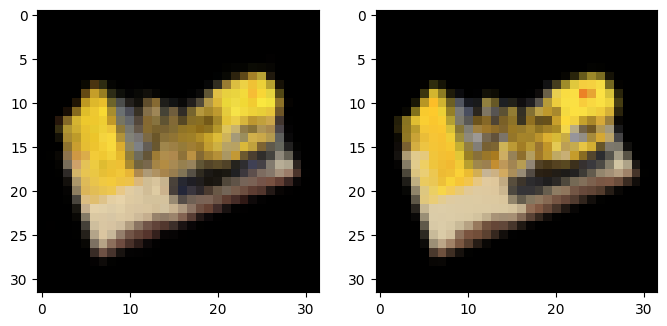

In [38]:
test_idx = torch.randint(images.shape[0], (1,)).item()
# test_idx = 17

plt.figure(figsize=(8,4))

predicted = predict(poses[test_idx]).detach()
plt.subplot(1,2,1)
plt.imshow(predicted)

plt.subplot(1,2,2)
plt.imshow(images[test_idx])

In [ ]:
# torch.save({'model_state': model.state_dict()},'checkpoints/001.chk')

In [17]:
# checkpoint = torch.load('checkpoints/001.chk')
# model.load_state_dict(checkpoint['model_state'])

In [22]:
def generate_random_angles():
    # Generate random theta between -90 and 90 degrees (pitch)
    theta = torch.rand(1) * 180 - 90  # Random value between -90 and 90
    
    # Generate random phi between 0 and 360 degrees (yaw)
    phi = torch.rand(1) * 360  # Random value between 0 and 360

    return theta.item(), phi.item()


def rot(theta, phi):
    theta = torch.tensor(theta) * (torch.pi / 180)
    phi = torch.tensor(phi) * (torch.pi / 180)

    R_x = torch.tensor([[1, 0, 0],
                        [0, torch.cos(theta), -torch.sin(theta)],
                        [0, torch.sin(theta), torch.cos(theta)]])

    R_y = torch.tensor([[torch.cos(phi), 0, torch.sin(phi)],
                        [0, 1, 0],
                        [-torch.sin(phi), 0, torch.cos(phi)]])

    return torch.matmul(R_y, R_x)

82.6253662109375 346.5287780761719


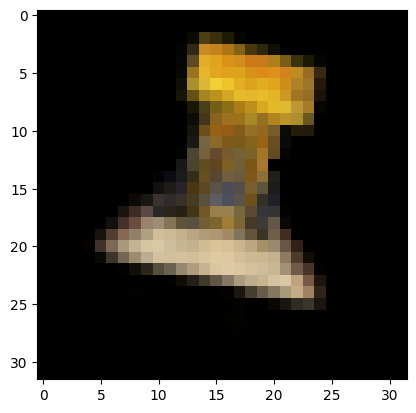

In [74]:
theta, phi = generate_random_angles()
print(theta, phi)

radius = 4
cam_rot = rot(theta, phi)
cam_backwards = cam_rot[:, -1]
cam_pos = radius * cam_backwards

fakepose = torch.eye(4)
fakepose[:3, :3] = cam_rot
fakepose[:3, -1] = cam_pos

plt.imshow(predict(fakepose).detach())